# Facial Age Group Estimation Model

Our Facial Age Group Estimation Model is meticulously crafted to predict the age group of individuals using facial images.

The model features a custom Convolutional Neural Network (CNN) architecture, comprising 5 Convolutional Blocks and incorporating regularization techniques. It is designed to make predictions across 5 distinct age group labels.

#### The model was built through the following steps:

#### Step 1 - Importing Required Libraries

In [1]:
import numpy as np 
import pandas as pd
from glob import glob 
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing import image
import os
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout

2023-11-23 00:32:02.191913: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Step 2 -  Data Directory and Configuration

In [2]:
# Define the paths to the train, test, and validation data
train_path = 'Faces_images/train'
test_path = 'Faces_images/test'
valid_path = 'Faces_images/validation'

# Get a list of folders in the train_path and sort them 
folders = sorted(glob(os.path.join(train_path, '*')), key=lambda x: int(os.path.basename(x).split('-')[0]) if '-' in os.path.basename(x) else int(os.path.basename(x).split('+')[0]))

# Define the image size and Batch size
IMAGE_SIZE = [224, 224]
batch_size = 32

# Define the class labels 
class_labels = ['0-3', '4+', '9+', '12+', '17+']

#### Step 3 - Image Data Augmentation and Normalization and Loading for Training, Validation, and Test Sets







In [3]:
# Data Augmentation for Training Set
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    shear_range=0.2,  # Shear transformation
    zoom_range=0.2,  # Zoom transformation
    horizontal_flip=True  # Horizontal flip
)

# Data normalization for Validation Set
validation_datagen = ImageDataGenerator(rescale=1./255)

# Data normalization for Test Set 
test_datagen = ImageDataGenerator(rescale=1./255)


# Data Generators for loading data into batches
training_set = train_datagen.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    class_mode='categorical',# Uses one-hot encoding
    classes=class_labels
)

validation_set = validation_datagen.flow_from_directory(
    valid_path,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    class_mode='categorical',# Uses one-hot encoding
    classes=class_labels
)

test_set = test_datagen.flow_from_directory(
    test_path,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    class_mode='categorical',# Uses one-hot encoding
    classes=class_labels
)

Found 13618 images belonging to 5 classes.
Found 1703 images belonging to 5 classes.
Found 1706 images belonging to 5 classes.


#### Step 4 - Building the CNN Model and compiling it and Early Stopping and Learning Rate Schedule 


In [4]:
# Building the model
input_layer = Input(shape=(224, 224, 3))

# Convolutional Block 1
x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(input_layer)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

# Convolutional Block 2
x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

# Convolutional Block 3
x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

# # Convolutional Block 4
x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
 
# Convolutional Block 5
x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

# Flatten and Fully Connected Layers with Dropout
x = Flatten()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Output Layer
output_layer = Dense(5, activation='softmax')(x)

# Create the model
model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

# Compiling the Model
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


# Print the model summary
model.summary()

# Early Stopping and Learning Rate Schedule
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-7)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 64)     256   

#### Step 5 - Training the Model


In [5]:
# Train the model
epochs = 20
history = model.fit(
    training_set,
    steps_per_epoch=len(training_set),
    validation_data=validation_set,
    validation_steps=len(validation_set),
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20


2023-11-23 00:32:10.077687: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


426/426 [==============================] - ETA: 0s - loss: 6.0137 - accuracy: 0.4161

2023-11-23 00:48:51.798006: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


426/426 [==============================] - 1039s 2s/step - loss: 6.0137 - accuracy: 0.4161 - val_loss: 3.0032 - val_accuracy: 0.2754 - lr: 0.0010
Epoch 2/20
426/426 [==============================] - 1028s 2s/step - loss: 2.4303 - accuracy: 0.4978 - val_loss: 2.4119 - val_accuracy: 0.2789 - lr: 0.0010
Epoch 3/20
426/426 [==============================] - 1029s 2s/step - loss: 2.0020 - accuracy: 0.5206 - val_loss: 2.1496 - val_accuracy: 0.3969 - lr: 0.0010
Epoch 4/20
426/426 [==============================] - 1054s 2s/step - loss: 1.8941 - accuracy: 0.5279 - val_loss: 4.6846 - val_accuracy: 0.2895 - lr: 0.0010
Epoch 5/20
426/426 [==============================] - 1093s 3s/step - loss: 1.9629 - accuracy: 0.5175 - val_loss: 2.4060 - val_accuracy: 0.4375 - lr: 0.0010
Epoch 6/20
426/426 [==============================] - 1042s 2s/step - loss: 1.6781 - accuracy: 0.5866 - val_loss: 1.6077 - val_accuracy: 0.5244 - lr: 1.0000e-04
Epoch 7/20
426/426 [==============================] - 1023s 2s/st

#### Step 6 - Evaluating the Model

In [6]:
# Evaluate the Model on the Test Set
test_loss, test_acc = model.evaluate(test_set, steps=len(test_set))
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')

2023-11-23 06:19:51.125747: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


54/54 [==============================] - 34s 615ms/step - loss: 0.7497 - accuracy: 0.7661
Test Loss: 0.7497201561927795
Test Accuracy: 0.7661195993423462


##### Confusion Matrix Visualization and Model Performance Report


In [7]:
# Initialize variables to store true and predicted labels
true_labels = []
predicted_labels = []

# Loop through the test set and make predictions
for i in range(len(test_set)):
    images, labels = test_set[i]
    true_labels.extend(np.argmax(labels, axis=1))
    predictions = model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))

# Convert the lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

1/1 [==============================] - 0s 339ms/step


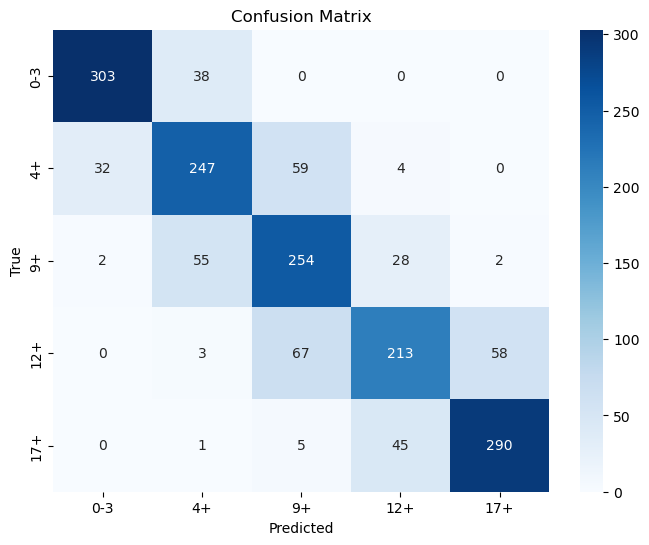

              precision    recall  f1-score   support

         0-3       0.90      0.89      0.89       341
          4+       0.72      0.72      0.72       342
          9+       0.66      0.74      0.70       341
         12+       0.73      0.62      0.68       341
         17+       0.83      0.85      0.84       341

    accuracy                           0.77      1706
   macro avg       0.77      0.77      0.77      1706
weighted avg       0.77      0.77      0.77      1706



In [8]:
# Create the confusion matrix
confusion_mtx = confusion_matrix(true_labels, predicted_labels)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Generate a classification report
report = classification_report(true_labels, predicted_labels, target_names=class_labels)
print(report)

#### Step 7 - Plotting Loss and Accuracy Curves

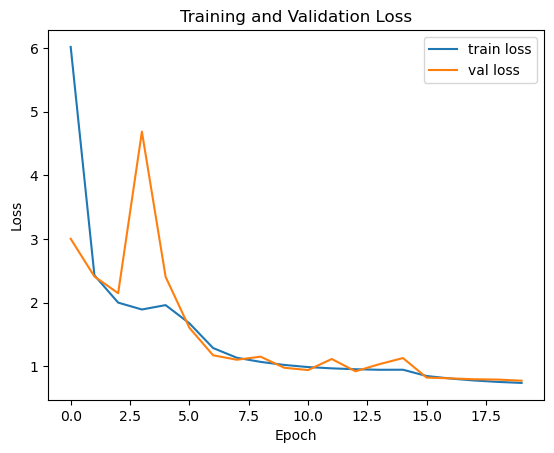

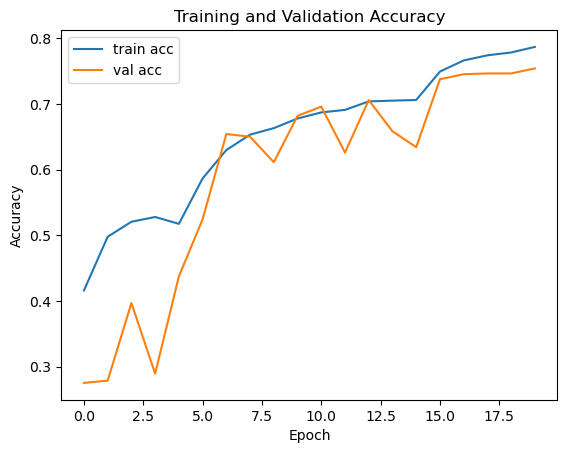

In [9]:
# Plotting Loss Curves
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

# Plotting Accuracy Curves
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()

#### Step 8- and the last one- Saving the Model

In [10]:
# Saving the Model
model.save('FacialAgeGroupEstimation_BestModel.h5')

##### The model exhibits promising training progress, achieving an accuracy of around 76.6% on the test data, and this is the best result we got from the training on facial age-group estimation. Also,  this percentage in age-group estimation does very well since it is a complex and challenging task. The model is saved for use on Game Geek website.